# Vorticity Streamfunction Equations (Cont.)
#### Hunter Lybbert
#### Student ID 2426454
#### 11-22-24

In [1]:
from typing import Optional

import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags, dia_matrix
from matplotlib import pyplot as plt

### This section is from HW 04
Helpful references are in the textbook, [Data-Driven Modeling & Scientific Computation](https://faculty.washington.edu/kutz/kutz_book_v2.pdf) by J. Nathan Kutz,  on pages 209 and 221.

In [2]:
def partial_in_x(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    upper = np.ones(n*n)
    lower = -1*np.ones(n*n)

    matrix = spdiags([upper, lower, lower, upper], diags=np.array([n, -n, n*(n - 1), -n*(n - 1)]))

    return matrix


def partial_in_y(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    upper = np.tile(np.repeat([0, 1], [1, n-1]), n)
    lower = np.tile(np.repeat([-1, 0], [n-1, 1]), n)

    upper_wrap_around = np.tile(np.repeat([0, -1], [n-1, 1]), n)
    lower_wrap_around = np.tile(np.repeat([1, 0], [1, n-1]), n)

    matrix = spdiags([upper, lower, upper_wrap_around, lower_wrap_around], diags=np.array([1, -1, n - 1, -n + 1]))

    return matrix


def second_gradient_x_y(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    main_diag = -4*np.ones(n*n)
    upper = np.tile(np.repeat([0, 1], [1, n-1]), n)
    lower = np.tile(np.repeat([1, 0], [n-1, 1]), n)
    
    upper_wrap_around = np.tile(np.repeat([0, 1], [n-1, 1]), n)
    lower_wrap_around = np.tile(np.repeat([1, 0], [1, n-1]), n)

    off_diag = np.ones(n*n)

    data = [
        main_diag,
        upper,
        lower,
        upper_wrap_around,
        lower_wrap_around,
        off_diag,
        off_diag,
        off_diag,
        off_diag
    ]
    diags = np.array(
        [
            0,
            1,
            -1,
            n - 1,
            -n + 1,
            n*(n - 1),
            -n*(n - 1),
            n,
            -n
        ]
    )

    matrix = spdiags(data, diags=diags)

    return matrix


def build_matrices(
    n: int,
    delta_x: float,
    delta_y: Optional[float] = None,
    output_as_np: Optional[bool] = False,
    output_as_csc: Optional[bool] = False,
) -> np.array:
    """
    
    :param n: the dimension of the (n,n) matrices
    :param delta_x: the step size in x
    :param delta_y: the step size in y
    :param output_as_np: 

    """
    if not delta_y:
        delta_y = delta_x

    if delta_x == delta_y:
        A = (1/(delta_x**2))*second_gradient_x_y(n)
        B = (1/(2*delta_x))*partial_in_x(n)
        C = (1/(2*delta_x))*partial_in_y(n)

    else:
        raise NotImplementedError("Currently do not support different step sizes in x and y")
    
    if output_as_np:
        A = A.toarray()
        B = B.toarray()
        C = C.toarray()

    if output_as_csc:
        A = A.tocsc()
        B = B.tocsc()
        C = C.tocsc()

    return A, B, C

In [3]:
def prob1(L, n) -> tuple[np.array]:
    """
    :param L: the upper bound on the range (-L,L) to solve the diff eq on
    :param n: the number of intervals to chop up out 2 spatial dimensions
    """
    delta_x = (L - (-L)) / n

    return build_matrices(n, delta_x=delta_x, output_as_np=True)

A1, A2, A3 = prob1(L=10, n=8)

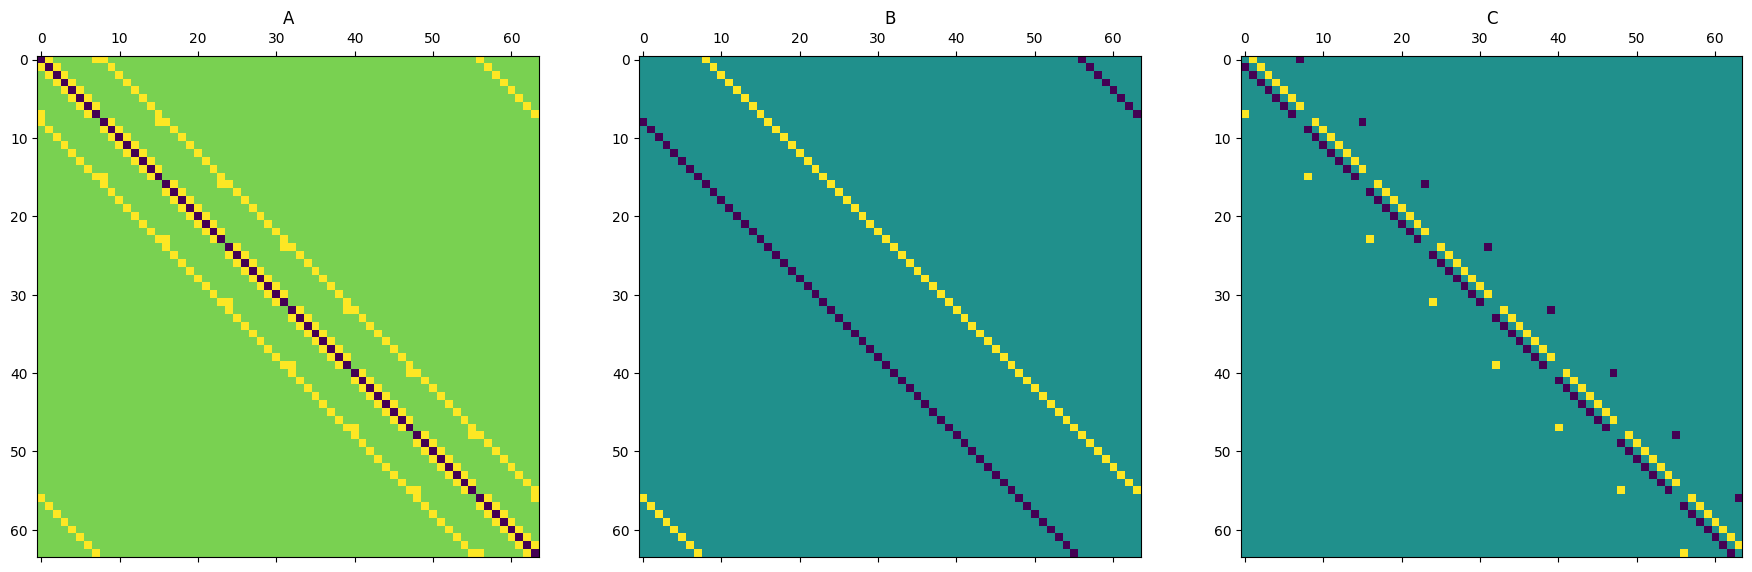

In [4]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(22)
fig.set_figheight(10)


ax[0].matshow(A1, cmap='viridis')
ax[0].set_title("A")
ax[1].matshow(A2, cmap='viridis')
ax[1].set_title("B")
ax[2].matshow(A3, cmap='viridis')
ax[2].set_title("C")
plt.show()

### Now we begin HW 5

#### A little pseudo code and math latex helpful stuff

set $\omega^t = \omega^0$

`For t in time:`

1) Solve $$A\psi^t = \omega^t$$
2) Time step update $$\omega^{t+1} = \omega^t + \Delta t \left[ \nu A\omega^t - \left( B\psi^t C\omega^t - C\psi^tB\omega^t \right) \right]$$

In [5]:
def omega_0_func(
    x: np.array,
    y: np.array,
    amplitude: float = 1,
    variance_in_x: float = 4,
    variance_in_y: float = 1,
    x_location: float = 0,
    y_location: float = 0,
) -> np.array:
    """
    Initial conditions for vorticity aka omega.

    :param x: the array indicating the linspace in the x spatial dimenstino
    :param y: the array indicating the linspace in the y spatial dimenstino
    :param amplitude: the height of the gaussian at x,y = (0,0)
    :param variance_in_x: measure of the spread of the gaussian in the x direction
    :param variance_in_y: measure of the spread of the gaussian in the y direction

    """
    exponent = (
        -(x - x_location)**2/variance_in_x
        -(y - y_location)**2/variance_in_y
    )
    return amplitude*np.exp(exponent)

def multi_omega_0_func(
    x, y, amplitudes, locations, variances
) -> np.array:
    """"""
    omega_0 = np.zeros_like(x)
    for k in range(len(amplitudes)):
        omega_0 += omega_0_func(
            x=x,
            y=y,
            amplitude=amplitudes[k],
            variance_in_x=variances[k][0],
            variance_in_y=variances[k][1],
            x_location=locations[k][0],
            y_location=locations[k][1],
        )
    return omega_0
    

In [6]:
# x_full = np.linspace(-10, 10, 64 + 1)
# y_full = np.linspace(-10, 10, 64 + 1)

# x_trunc = x_full[:64]
# y_trunc = y_full[:64]

# X, Y = np.meshgrid(x_trunc, y_trunc)
# omega_0_mat: np.array = multi_omega_0_func(
#     x=X,
#     y=Y,
#     amplitudes=np.array([1, 1]),
#     variances=np.array([[1, 20], [4, 1]]),
#     locations=np.array([[0, 0], [5, 5]]),
# )

# omega_0_mat

In [7]:
# plt.pcolor(omega_0_mat)
# plt.show()

In [8]:
# from scipy.stats import multivariate_normal

# mean = np.array([0, 0])
# cov = np.array([[4, 6],[5, 20]])

# rv = multivariate_normal(
#     mean=mean,
#     cov=cov,
# )

# rank = np.linalg.matrix_rank(cov)
# scale = np.sqrt( ((2 * np.pi)**rank) * np.linalg.det(cov) )

In [9]:
# fig, ax = plt.subplots(1,2)
# fig.set_figwidth(12)

# ax[0].contourf(rv.pdf(np.dstack((X, Y))))
# ax[1].contourf(scale*rv.pdf(np.dstack((X, Y))))

In [10]:
import os
import time

from typing import Any
from enum import Enum, member

from scipy.fftpack import fft2, ifft2
from scipy.sparse import linalg as sp_la
from scipy import linalg as reg_la

import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib notebook

In [11]:
def incriment_file(base_filename: str, directory: str) -> None:
    """
    returns file name incrimented appropriately
    """
    # Extract the name and extension
    name, ext = os.path.splitext(base_filename)
    path = os.path.join(directory, base_filename)

    # Check if the file already exists
    counter = 0
    while os.path.exists(path):
        # Add or update the suffix
        path = os.path.join(directory, f"{name}_{counter}{ext}")
        counter += 1

    return path


def fourier_solve(
    omega: np.array,
    kx: np.array,
    ky: np.array,
) -> np.array:
    """This should be an nxn array in and out"""
    derivative_terms = kx**2 + ky**2
    omega_ft = -fft2(omega)/derivative_terms
    psi = ifft2(omega_ft)
    return np.real(psi)


def spab_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int
) -> np.array:
    """"""
    omega_vec = omega.reshape(reshape_dim**2)
    psi_vec = sp_la.spsolve(laplacian, omega_vec)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    return psi_mat


def ab_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int
) -> np.array:
    """"""
    laplacian = laplacian.toarray()
    omega_vec = omega.reshape(reshape_dim**2)

    psi_vec = reg_la.solve(laplacian, omega_vec)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    return psi_mat


def splu_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int,
) -> np.array:
    """"""
    omega_vec = omega.reshape(reshape_dim**2)
    A = sp_la.splu(laplacian)
    psi_vec = A.solve(omega_vec)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    return psi_mat


def lu_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int,
) -> np.array:
    """"""
    laplacian = laplacian.toarray()
    omega_vec = omega.reshape(reshape_dim**2)

    P, L, U = reg_la.lu(laplacian)

    P_omega = np.dot(P, omega_vec)
    LP_omega = reg_la.solve_triangular(L, P_omega, lower=True)
    psi_vec = reg_la.solve_triangular(U, LP_omega)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    
    return psi_mat


def bicgstab_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int,
    tol: float = 1e-6,
) -> np.array:
    """"""
    omega_vec = omega.reshape(reshape_dim**2)
    psi_vec, exit_code = sp_la.bicgstab(laplacian, omega_vec, atol=tol)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    return psi_mat


def gmres_solve(
    omega: np.array,
    laplacian: np.array,
    reshape_dim: int,
    tol: float = 1e-6,
) -> np.array:
    """"""
    omega_vec = omega.reshape(reshape_dim**2)
    psi_vec, exit_code = sp_la.gmres(laplacian, omega_vec, atol=tol)
    psi_mat = psi_vec.reshape((reshape_dim, reshape_dim))
    return psi_mat


class LinearSystemSolveMethods(Enum):
    """
    Options of how to solve system
    """
    fourier = member(fourier_solve)
    spab = member(spab_solve)
    ab = member(ab_solve)
    splu = member(splu_solve)
    lu = member(lu_solve)
    bicgstab = member(bicgstab_solve)
    gmres = member(gmres_solve)

In [23]:
class VorticityStreamFunctionSolver:
    """A clase to configure and solve the Vorticity Stream Function Differential Equation."""
    
    def __init__(
        self,
        nu: float,
        L: int,
        n: float,
        omega_0_params: dict[str, Any],
        solve_method_name: str = LinearSystemSolveMethods.fourier.name,
        tol: Optional[float] = 1e-6,
    ) -> None:
        """
        Initialize Everything.
        
        :param nu: customizable parameter, no clear interpretation yet

        :returns: None
        """
        self.L: int = L
        self.n: float = n
        self.nu: float = nu

        self.solve_method_name = solve_method_name
        # TODO Change back
        self.solve_method_func = LinearSystemSolveMethods[solve_method_name].value
        self.solve_method_params = dict()

        self._setup_omega_0(omega_0_params)
        self._setup_diff_matrices()

        # TODO Change back
        if self.solve_method_name == LinearSystemSolveMethods.fourier.name:
            self._setup_wavenumbers()
        else:
            self._setup_solve_method_params(tol=tol)

    def _setup_omega_0(self, omega_0_params: dict[str, Any]) -> None:
        """
        """
        x_full = np.linspace(-self.L, self.L, self.n + 1)
        y_full = np.linspace(-self.L, self.L, self.n + 1)

        x_trunc = x_full[:self.n]
        y_trunc = y_full[:self.n]

        self.X, self.Y = np.meshgrid(x_trunc, y_trunc)
        # omega_0_mat: np.array = omega_0_func(
        #     x=self.X,
        #     y=self.Y,
        #     **omega_0_params
        # )
        omega_0_mat: np.array = multi_omega_0_func(
            x=self.X,
            y=self.Y,
            **omega_0_params,
        )
        omega_0_vec: np.array = omega_0_mat.reshape(self.n*self.n)
        self.omega_0 = omega_0_vec

    def _setup_diff_matrices(self) -> None:
        """
        """
        delta_x = ( self.L - (-self.L))/self.n
        self.A, self.B, self.C = build_matrices(n=self.n, delta_x=delta_x, output_as_csc=True)

    def _setup_wavenumbers(self) -> None:
        """
        """
        scale_factor = 2 * np.pi / (self.L - (-self.L))
        kx = scale_factor * np.concatenate((np.arange(0, self.n/2), np.arange(-self.n/2, 0)))
        ky = scale_factor * np.concatenate((np.arange(0, self.n/2), np.arange(-self.n/2, 0)))

        # avoid divide by zero with floating point precision error
        kx[0] = 1e-6
        ky[0] = 1e-6
        self.kx, self.ky = np.meshgrid(kx, ky)
        self.solve_method_params = {
            "kx": self.kx,
            "ky": self.ky,
        }
    
    def _setup_solve_method_params(self, tol: Optional[float] = 1e-6) -> None:
        """"""
        self.A[0,0] = 2
        self.solve_method_params = {
            "laplacian": self.A,
            "reshape_dim": self.n,
        }
        # TODO Change back
        methods_use_tol = [LinearSystemSolveMethods.bicgstab.name, LinearSystemSolveMethods.gmres.name]
        if self.solve_method_name in methods_use_tol:
            self.solve_method_params.update({"tol": tol})

    def omega_ode_rhs(self, t: float, omega: np.array):
        """Define the ODE."""
        omega_mat = omega.reshape((self.n, self.n))

        psi_mat = self.solve_method_func(omega_mat, **self.solve_method_params)
        psi = psi_mat.reshape(self.n*self.n)

        diffusion = self.nu * self.A@omega
        advection = ((self.B@psi) * (self.C@omega)) - ((self.C@psi) * (self.B@omega))
        final = diffusion - advection

        return final
    
    def solve(self, tspan: np.array) -> None:
        """Solve the ODE with solve_ivp."""

        start_time = time.time()
        self.omega_sol = solve_ivp(
            self.omega_ode_rhs,
            t_span=(tspan[0], tspan[-1]),
            y0=self.omega_0,
            method="RK45",
            t_eval=tspan,
        )
        end_time = time.time()
        self.time_to_solve = end_time - start_time
        
        return self.omega_sol

    def plot(self, step: int) -> None:
        """"""
        plt.pcolor(self.omega_sol.y[:,step].reshape((self.n,self.n)))
        plt.show()

    def create_animation(self, tspan: np.array, save: bool):
        """Create animation of the system as time evolved."""
        animation.writer = animation.writers['ffmpeg']

        plt.ioff()
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # write the update function, specifically including the ax.clear() function this was important.
        def update(i):
            ax.clear()
            ax.pcolor(self.X, self.Y, self.omega_sol.y[:,i].reshape((self.n, self.n)), cmap='viridis')
            ax.set_title("Solution to Vorticity Stream Function")
            return ax

        self.ani = animation.FuncAnimation(fig, update, frames=range(len(tspan)), interval=50)

        if save:
            self._save_animation()

    def _save_animation(self) -> None:
        # Save gif
        file_name = incriment_file("vorticity_stream_function.gif", "visuals")
        self.ani.save(file_name, writer='pillow')

        # Save as MP4
        file_name_mp4 = incriment_file("vorticity_stream_function.mp4", "visuals")
        writer = animation.writers['ffmpeg']
        writer = writer(fps=10, metadata=dict(artist='Hunter Lybbert'), bitrate=1800)
        self.ani.save(file_name_mp4, writer=writer)

In [24]:
def homework_generate_A1(
    plot: bool = True,
    animate: bool = True,
) -> None:
    """
    Solve the system

    :returns: None
    """
    L = 10
    n = 64
    nu = 0.001  # as given in the assignment
    tspan = np.arange(0, 4.5, .5)
    omega_0_params = {
        "amplitudes": np.array([1]),
        "locations": np.array([[0, 0]]),
        "variances":np.array([[1, 20]]),
    }

    VSFSolver = VorticityStreamFunctionSolver(
        nu=nu,
        L=L,
        n=n,
        omega_0_params=omega_0_params,
        solve_method_name=LinearSystemSolveMethods.fourier.name,
    )
    VSFSolver.solve(tspan=tspan)

    if plot or animate:
        VSFSolver.create_animation(tspan, save=False)

    return VSFSolver.omega_sol.y

# A1 = homework_generate_A1()

In [25]:
def homework_generate_A2(
    plot: bool = True,
    animate: bool = True,
) -> None:
    """
    Solve the system

    :returns: None
    """
    L = 10
    n = 64
    nu = 0.001  # as given in the assignment
    tspan = np.arange(0, 4.5, .5)
    omega_0_params = {
        "amplitudes": np.array([1]),
        "locations": np.array([[0, 0]]),
        "variances":np.array([[1, 20]]),
    }

    VSFSolver = VorticityStreamFunctionSolver(
        nu=nu,
        L=L,
        n=n,
        omega_0_params=omega_0_params,
        solve_method_name=LinearSystemSolveMethods.ab.name
    )
    VSFSolver.solve(tspan=tspan)

    if plot or animate:
        VSFSolver.create_animation(tspan, save=False)

    return VSFSolver.omega_sol.y

# A2 = homework_generate_A2()

In [26]:
def homework_generate_A3(
    plot: bool = True,
    animate: bool = True,
) -> None:
    """
    Solve the system

    :returns: None
    """
    L = 10
    n = 64
    nu = 0.001  # as given in the assignment
    tspan = np.arange(0, 4.5, .5)
    omega_0_params = {
        "amplitudes": np.array([1]),
        "locations": np.array([[0, 0]]),
        "variances":np.array([[1, 20]]),
    }

    VSFSolver = VorticityStreamFunctionSolver(
        nu=nu,
        L=L,
        n=n,
        omega_0_params=omega_0_params,
        solve_method_name=LinearSystemSolveMethods.lu.name,
    )
    VSFSolver.solve(tspan=tspan)

    if plot or animate:
        VSFSolver.create_animation(tspan, save=False)

    return VSFSolver.omega_sol.y

# A3 = homework_generate_A3()

In [30]:
def solve_vorticity_streamfunction(
    plot: bool = True,
    animate: bool = True,
) -> None:
    """
    Solve the system

    :returns: None
    """
    L = 18
    n = 128
    nu = 0.001  # as given in the assignment
    tspan = np.arange(0, 50.25, .25)
    # omega_0_params = {
    #     "amplitudes": np.array([1]),
    #     "locations": np.array([[0, 0]]),
    #     "variances":np.array([[1, 20]]),
    # }
    omega_0_params = {
        "amplitudes": np.array([1, -1, 1, -1, -1, -1, 1, 1, 1]),
        "variances": np.array([[1, 20], [10, 1], [10, 1], [10, 1], [20, 1], [5, 1], [20, 1], [20, 1], [20, 4]]),
        "locations": np.array([[-1, -1], [-8, -5], [-2, 8], [5, 5], [1, 1], [-8, 5], [-9, -11], [-7, -8], [8, 7]]),
    }

    VSFSolver = VorticityStreamFunctionSolver(
        nu=nu,
        L=L,
        n=n,
        omega_0_params=omega_0_params,
        solve_method_name=LinearSystemSolveMethods.fourier.name
    )
    VSFSolver.solve(tspan=tspan)

    if plot or animate:
        VSFSolver.create_animation(tspan, save=True)

    return VSFSolver

solver = solve_vorticity_streamfunction()

In [31]:
# reg ab 9.455193042755127
# sparse ab 0.27076220512390137
# reg lu 14.964174032211304
# splu 0.2720508575439453
# bicgstab 0.7590529918670654
# gmres 17.59000301361084
solver.time_to_solve

0.38754892349243164

#### This is where the fun begins

In [29]:
HTML(solver.ani.to_html5_video())